# Limpieza de datos con PySpark: Data Science Job Posting on Glassdoor

Los [datos](https://tajamar365.sharepoint.com/:x:/s/3405-MasterIA2024-2025/ETYTQ0c-i6FLjM8rZ4iT1cgB6ipFAkainM-4V9M8DXsBiA?e=PeMtvh) fueron extraídos (scrapeados) del sitio web de Glassdoor y recoge los salarios de distintos puestos relacionados a Data.

In [2]:
!pip install pyspark

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Caso4").getOrCreate()


In [4]:
from google.colab import files

uploaded = files.upload()

Saving ds-jobs.csv to ds-jobs.csv


### Resolver los siguientes requerimientos, para cada operación/moficación imprima como van quedadndo los cambios.

1. Cargar los datos y mostrar el esquema o la informacion de las columnas y el tip de dato de cada columna

In [5]:
df = spark.read.option("header", "true") \
               .option("delimiter", ";") \
               .option("multiline", "true") \
               .option("encoding", "UTF-8") \
               .csv("ds-jobs.csv")

df.printSchema()

root
 |-- index: string (nullable = true)
 |-- Job Title: string (nullable = true)
 |-- Salary Estimate: string (nullable = true)
 |-- Job Description: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Company Name: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Headquarters: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- Founded: string (nullable = true)
 |-- Type of ownership: string (nullable = true)
 |-- Industry: string (nullable = true)
 |-- Sector: string (nullable = true)
 |-- Revenue: string (nullable = true)
 |-- Competitors: string (nullable = true)



In [6]:
df.show()

+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-----------------+--------------------+--------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|               index|           Job Title|     Salary Estimate|     Job Description|       Rating|        Company Name|         Location|        Headquarters|                Size|          Founded|   Type of ownership|            Industry|              Sector|             Revenue|         Competitors|
+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-----------------+--------------------+--------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                   0|   Sr Data Scientist|$137K-$171K (Glas...|Description\n\nTh...|   

Vemos que todos los campos están en tipo string, por lo que, cuando queramos hacer alguna media, suma, u operaciones con enteros, sería recomendable hacer un cast de esa columna

2. Eliminar duplicados

In [7]:
from pyspark.sql.functions import col, count, countDistinct

print(f"Filas antes de borrar duplicados {df.count()}")

df = df.dropDuplicates()

print(f"Filas despues de borrar duplicados {df.count()}")


Filas antes de borrar duplicados 733
Filas despues de borrar duplicados 709


3. Decidir que hacer con los datos faltantes

Primero contamos cuantos datos faltantes hay por cada columna, y dependiendo del valor que tenga esa columna, decidimos.

In [8]:
from pyspark.sql import functions as F

for column in df.columns:
    empty_count = df.filter((F.col(column) == "-1")).count()
    print(f"Columna '{column}': {empty_count} valores vacíos")


Columna 'index': 0 valores vacíos
Columna 'Job Title': 2 valores vacíos
Columna 'Salary Estimate': 0 valores vacíos
Columna 'Job Description': 0 valores vacíos
Columna 'Rating': 38 valores vacíos
Columna 'Company Name': 2 valores vacíos
Columna 'Location': 4 valores vacíos
Columna 'Headquarters': 20 valores vacíos
Columna 'Size': 17 valores vacíos
Columna 'Founded': 104 valores vacíos
Columna 'Type of ownership': 16 valores vacíos
Columna 'Industry': 78 valores vacíos
Columna 'Sector': 59 valores vacíos
Columna 'Revenue': 15 valores vacíos
Columna 'Competitors': 461 valores vacíos




Visto el resultado, vamos a realizar lo siguiente para cada columna con datos faltantes:
- Job Title --> eliminar ya que sin título el dato no vale
- Rating --> ponemos la media de todas las ratings
- Company name --> eliminamos porque son pocas filas y sin nombre de la compañía el dato pierde valor
- Location --> intentaremos coger el dato de headquarters, si es nulo, eliminamos
- Headquarters --> igual que location pero al revés
- Size --> ponemos lit(none), no nos aporta gran información
- Founded --> ponemos lit(none), no nos aporta gran información
- Industry, sector, type of ownership, revenue y competitors --> lo dejaremos en lit(Unknown), ya que es importante pero no estrictamente necesaria la informacion

In [9]:
from pyspark.sql import functions as F

# Paso 1: Eliminar filas donde Job Title sea "-1"
df_cleaned = df.filter(F.col("Job Title") != "-1")

# Paso 2: Rellenar Rating con la media de la columna, donde Rating sea "-1", para ello, primero hay que pasar rating a int
df_cleaned = df.withColumn("Rating", F.col("Rating").cast("int"))
average_rating = df.filter(F.col("Rating") != -1).agg(F.round(F.avg("Rating"), 2)).collect()[0][0]
df_cleaned = df_cleaned.withColumn("Rating", F.when(F.col("Rating") == -1, average_rating).otherwise(F.col("Rating")))

# Paso 3: Eliminar filas donde Company name sea "-1"
df_cleaned = df_cleaned.filter(F.col("Company name") != "-1")

# Paso 4: Limpiar Location: si es "-1", tomar el valor de Headquarters, si ambos son "-1", eliminar fila
df_cleaned = df_cleaned.withColumn(
    "Location",
    F.when(F.col("Location") == "-1", F.col("Headquarters")).otherwise(F.col("Location"))
)
df_cleaned = df_cleaned.filter(F.col("Location") != "-1")

# Paso 5: Limpiar Headquarters: si es "-1", tomar el valor de Location, si ambos son "-1", eliminar fila
df_cleaned = df_cleaned.withColumn(
    "Headquarters",
    F.when(F.col("Headquarters") == "-1", F.col("Location")).otherwise(F.col("Headquarters"))
)
df_cleaned = df_cleaned.filter(F.col("Headquarters") != "-1")

# Paso 6: Reemplazar valores "-1" de Size con "none"
df_cleaned = df_cleaned.withColumn("Size", F.when(F.col("Size") == "-1", "none").otherwise(F.col("Size")))

# Paso 7: Reemplazar valores "-1" de Founded con "none"
df_cleaned = df_cleaned.withColumn("Founded", F.when(F.col("Founded") == "-1", "none").otherwise(F.col("Founded")))

# Paso 8: Reemplazar valores "-1" de Industry, Sector, Revenue, Competitors con "Unknown"
df_cleaned = df_cleaned.withColumn("Industry", F.when(F.col("Industry") == "-1", "Unknown").otherwise(F.col("Industry")))
df_cleaned = df_cleaned.withColumn("Sector", F.when(F.col("Sector") == "-1", "Unknown").otherwise(F.col("Sector")))
df_cleaned = df_cleaned.withColumn("Revenue", F.when(F.col("Revenue") == "-1", "Unknown").otherwise(F.col("Revenue")))
df_cleaned = df_cleaned.withColumn("Competitors", F.when(F.col("Competitors") == "-1", "Unknown").otherwise(F.col("Competitors")))
df_cleaned = df_cleaned.withColumn("Type of ownership", F.when(F.col("Type of ownership") == "-1", "Unknown").otherwise(F.col("Type of ownership")))


# Asignar el dataframe limpio al dataframe principal
df = df_cleaned

# Mostrar el dataframe limpio
df.show()


+-----+--------------------+--------------------+--------------------+------+--------------------+-----------------+--------------------+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+
|index|           Job Title|     Salary Estimate|     Job Description|Rating|        Company Name|         Location|        Headquarters|                Size|Founded|   Type of ownership|            Industry|              Sector|             Revenue|         Competitors|
+-----+--------------------+--------------------+--------------------+------+--------------------+-----------------+--------------------+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+
|   56|Senior Data Scien...|$75K-$131K (Glass...|Benson Hill empow...|  35.0|    Benson Hill\n3.5|  Saint Louis, MO|     Saint Louis, MO|201 to 500 employees|   2012|   Company - Priva

4. Decidir que hacer con los valores nulos

Con los nulos, vamos a hacer el mismo análisis que con los faltantes

In [10]:
for column in df.columns:
    empty_count = df.filter((F.col(column).isNull())).count()
    print(f"Columna '{column}': {empty_count} valores nulos")

Columna 'index': 0 valores nulos
Columna 'Job Title': 0 valores nulos
Columna 'Salary Estimate': 1 valores nulos
Columna 'Job Description': 1 valores nulos
Columna 'Rating': 27 valores nulos
Columna 'Company Name': 0 valores nulos
Columna 'Location': 0 valores nulos
Columna 'Headquarters': 0 valores nulos
Columna 'Size': 0 valores nulos
Columna 'Founded': 0 valores nulos
Columna 'Type of ownership': 0 valores nulos
Columna 'Industry': 0 valores nulos
Columna 'Sector': 24 valores nulos
Columna 'Revenue': 26 valores nulos
Columna 'Competitors': 27 valores nulos


A la vista de los resultados, amos a realizar lo mismo con los nulos que con los faltantes, pero añadiendo condiciones para Salary Estimate y Job Description, que también dejaremos en Unknown en caso de nulo

In [11]:
# Paso 1: Eliminar filas con Job Title nulo o vacío
df_cleaned = df.filter(F.col("Job Title").isNotNull() & (F.col("Company name") != ""))

# Paso 2: Rellenar Rating con la media de la columna
average_rating = df_cleaned.agg(F.round(F.avg("Rating"), 2)).collect()[0][0]
df_cleaned = df_cleaned.fillna({"Rating": average_rating})

# Paso 3: Eliminar filas con Company Name nulo o vacío
df_cleaned = df_cleaned.filter(F.col("Company name").isNotNull() & (F.col("Company name") != ""))

# Paso 4: Limpiar Location: si es nulo, tomar el valor de Headquarters, si ambos son nulos, eliminar fila
df_cleaned = df_cleaned.withColumn(
    "Location",
    F.coalesce(F.col("Location"), F.col("Headquarters"))
).filter(F.col("Location").isNotNull())

# Paso 5: Limpiar Headquarters: si es nulo, tomar el valor de Location, si ambos son nulos, eliminar fila
df_cleaned = df_cleaned.withColumn(
    "Headquarters",
    F.coalesce(F.col("Headquarters"), F.col("Location"))
).filter(F.col("Headquarters").isNotNull())

# Paso 6: Reemplazar valores nulos de Size y Founded con "none"
df_cleaned = df_cleaned.fillna({
    "Size": "none",
    "Founded": "none"
    })

# Paso 7: Reemplazar valores nulos de Industry, Sector, Revenue, Competitors con "Unknown"
df_cleaned = df_cleaned.fillna({
    "Industry": "Unknown",
    "Sector": "Unknown",
    "Revenue": "Unknown",
    "Type of ownership": "Unknown",
    "Competitors": "Unknown",
    "Salary Estimate": "Unknown",
    "Job Description": "Unknown"
})

# Asignar el dataframe limpio al principal
df = df_cleaned


# Mostrar el resultado
df.show()

+-----+--------------------+--------------------+--------------------+------+--------------------+-----------------+--------------------+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+
|index|           Job Title|     Salary Estimate|     Job Description|Rating|        Company Name|         Location|        Headquarters|                Size|Founded|   Type of ownership|            Industry|              Sector|             Revenue|         Competitors|
+-----+--------------------+--------------------+--------------------+------+--------------------+-----------------+--------------------+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+
|   56|Senior Data Scien...|$75K-$131K (Glass...|Benson Hill empow...|  35.0|    Benson Hill\n3.5|  Saint Louis, MO|     Saint Louis, MO|201 to 500 employees|   2012|   Company - Priva

Por último, vamos a comprobar que no haya ningún valor nulo ni vacío en nuestro dataframe, ejecutando el mismo código de antes

In [12]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType

for column in df.columns:
    if df.schema[column].dataType == StringType():
        empty_count = df.filter((F.col(column).isNull()) | (F.col(column) == "-1")).count()
    else:
        empty_count = df.filter(F.col(column).isNull()).count()
    print(f"Columna '{column}': {empty_count} valores nulos")

Columna 'index': 0 valores nulos
Columna 'Job Title': 0 valores nulos
Columna 'Salary Estimate': 0 valores nulos
Columna 'Job Description': 0 valores nulos
Columna 'Rating': 0 valores nulos
Columna 'Company Name': 0 valores nulos
Columna 'Location': 0 valores nulos
Columna 'Headquarters': 0 valores nulos
Columna 'Size': 0 valores nulos
Columna 'Founded': 0 valores nulos
Columna 'Type of ownership': 0 valores nulos
Columna 'Industry': 0 valores nulos
Columna 'Sector': 0 valores nulos
Columna 'Revenue': 0 valores nulos
Columna 'Competitors': 0 valores nulos


5. ¿Cuántos registros tiene el csv?

In [13]:
df.count()

653

El csv contiene 653 registros tras la limpieza

6. Mostrar los valores únicos de `Job title`

In [14]:
df.select("Job Title").distinct().show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Job Title                                                                                                                                                                                                                                                                                                                                                                                                                                                    |
+-------------------------------------------------------------------------------------------------------

7. Remover la letra `K` de la columna `Salary Estimate` y multiplicar por 1000.

In [15]:
df_cleaned = df.withColumn("Salary Estimate", F.regexp_replace(F.col("Salary Estimate"), "K", ".000"))
df = df_cleaned
df.select("Salary Estimate").show(truncate= False)

+----------------------------------+
|Salary Estimate                   |
+----------------------------------+
|$75.000-$131.000 (Glassdoor est.) |
|$91.000-$150.000 (Glassdoor est.) |
|$79.000-$131.000 (Glassdoor est.) |
|$56.000-$97.000 (Glassdoor est.)  |
|$69.000-$116.000 (Glassdoor est.) |
|$105.000-$167.000 (Glassdoor est.)|
|$137.000-$171.000 (Glassdoor est.)|
|$90.000-$109.000 (Glassdoor est.) |
|$101.000-$165.000 (Glassdoor est.)|
|$145.000-$225.000(Employer est.)  |
|$101.000-$165.000 (Glassdoor est.)|
|$31.000-$56.000 (Glassdoor est.)  |
|$92.000-$155.000 (Glassdoor est.) |
|$75.000-$131.000 (Glassdoor est.) |
|$75.000-$131.000 (Glassdoor est.) |
|$66.000-$112.000 (Glassdoor est.) |
|$79.000-$106.000 (Glassdoor est.) |
|$79.000-$133.000 (Glassdoor est.) |
|$212.000-$331.000 (Glassdoor est.)|
|$90.000-$124.000 (Glassdoor est.) |
+----------------------------------+
only showing top 20 rows



La salida nos devuelve efectivamente que la información de Salary Estimate está modificada con miles de dólares

8. Mostrar los valores únicos del campo `Salary Estimate`

In [16]:
df.select("Salary Estimate").distinct().show(truncate=False)

+----------------------------------+
|Salary Estimate                   |
+----------------------------------+
|Thumbtack\n3.9                    |
|Western Digital\n3.5              |
|42                                |
|$92.000-$155.000 (Glassdoor est.) |
|$75.000-$131.000 (Glassdoor est.) |
|$90.000-$109.000 (Glassdoor est.) |
|$141.000-$225.000 (Glassdoor est.)|
|$101.000-$165.000 (Glassdoor est.)|
|$128.000-$201.000 (Glassdoor est.)|
|$110.000-$163.000 (Glassdoor est.)|
|IZEA\n4.2                         |
|0                                 |
|$212.000-$331.000 (Glassdoor est.)|
|$79.000-$106.000 (Glassdoor est.) |
|$99.000-$132.000 (Glassdoor est.) |
|hc1\n2.9                          |
|$122.000-$146.000 (Glassdoor est.)|
|Giving Assistant\n4.8             |
|Jobot\n5.0                        |
|$87.000-$141.000 (Glassdoor est.) |
+----------------------------------+
only showing top 20 rows



9. Eliminar `(Glassdoor est.)` y `(Employer est.)` del campo `Salary Estimate`

In [17]:
df_cleaned = df.withColumn("Salary Estimate", F.regexp_replace(F.col("Salary Estimate"), "\(Glassdoor est.\)", ""))
df_cleaned = df_cleaned.withColumn("Salary Estimate", F.regexp_replace(F.col("Salary Estimate"), "\(Employer est.\)", ""))

df = df_cleaned
df.select("Salary Estimate").show(truncate= False)

+------------------+
|Salary Estimate   |
+------------------+
|$75.000-$131.000  |
|$91.000-$150.000  |
|$79.000-$131.000  |
|$56.000-$97.000   |
|$69.000-$116.000  |
|$105.000-$167.000 |
|$137.000-$171.000 |
|$90.000-$109.000  |
|$101.000-$165.000 |
|$145.000-$225.000 |
|$101.000-$165.000 |
|$31.000-$56.000   |
|$92.000-$155.000  |
|$75.000-$131.000  |
|$75.000-$131.000  |
|$66.000-$112.000  |
|$79.000-$106.000  |
|$79.000-$133.000  |
|$212.000-$331.000 |
|$90.000-$124.000  |
+------------------+
only showing top 20 rows



10. Mostrar de mayor a menor los valores del campo `Salary Estimate`

In [18]:
df.select("Salary Estimate").orderBy(F.col("Salary Estimate").desc()).show(truncate=False)

+-----------------------------------+
|Salary Estimate                    |
+-----------------------------------+
|hc1\n2.9                           |
|Western Digital\n3.5               |
|Upstart\n4.2                       |
|Unknown                            |
|Thumbtack\n3.9                     |
|Software Engineering Institute\n2.6|
|Royce Geospatial\n5.0              |
|Relativity\n3.7                    |
|Qurate Retail Group\n3.6           |
|Numeric, LLC\n3.2                  |
|Novartis\n3.9                      |
|Natera\n3.9                        |
|Mathematica Policy Research\n3.4   |
|LinQuest\n3.9                      |
|Life360\n3.9                       |
|Jobot\n5.0                         |
|Intellectual Ventures\n3.3         |
|IZEA\n4.2                          |
|HPOne\n3.5                         |
|Giving Assistant\n4.8              |
+-----------------------------------+
only showing top 20 rows



Al ver que hay muchos datos en la columna Salary Estimate que no coinciden con ningún número ni ningún salario estimado, voy a proceder a eliminar esta información y voy a reajustar los datos de salario aproximado de la siguiente manera:

- Todas las filas que no contengan valores numéricos precedidos por el símbolo del dolar, las pondré a $0.0

In [19]:
df_cleaned = df.withColumn("Salary Estimate", F.when(F.col("Salary Estimate").contains("$"), F.col("Salary Estimate")).otherwise(F.lit("$0.0")))

df = df_cleaned

df.select("Salary Estimate").orderBy(F.col("Salary Estimate").desc()).show(truncate=False)

+-----------------+
|Salary Estimate  |
+-----------------+
|$99.000-$132.000 |
|$99.000-$132.000 |
|$99.000-$132.000 |
|$99.000-$132.000 |
|$99.000-$132.000 |
|$99.000-$132.000 |
|$99.000-$132.000 |
|$99.000-$132.000 |
|$99.000-$132.000 |
|$99.000-$132.000 |
|$99.000-$132.000 |
|$99.000-$132.000 |
|$99.000-$132.000 |
|$99.000-$132.000 |
|$99.000-$132.000 |
|$99.000-$132.000 |
|$99.000-$132.000 |
|$99.000-$132.000 |
|$99.000-$132.000 |
|$99.000-$132.000 |
+-----------------+
only showing top 20 rows



De esta manera, hemos conseguido limpiar aquellos datos que no nos daban información buena y hemos filtrado en orden descendente los datos de Salary Estimate

11. De la columna `Job Description` quitar los saltos de linea `\n` del texto

In [20]:
df_cleaned = df.withColumn("Job Description", F.regexp_replace(F.col("Job Description"), "\n", " ")) \
  .withColumn("Job Description", F.regexp_replace("Job Description", r"[^\x00-\x7F]", "")) \
  .withColumn("Job Description", F.regexp_replace("Job Description", r"\*", ""))

df = df_cleaned

df.select("Job Description").show(truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

He decidido limpiar los siguientes caracteres para tener el texto limpio de Job Description:

- caracteres no ASCII

- asteriscos (*)

- saltos de línea (\n)

La salida nos muestra texto limpio y sin caracteres raros

12. De la columna `Rating` muestre los valores unicos.

In [21]:
df.select("Rating").distinct().show(truncate=False)

df.select("Rating").distinct().count()


+------+
|Rating|
+------+
|49.0  |
|29.0  |
|38.84 |
|47.0  |
|42.0  |
|44.0  |
|35.0  |
|39.0  |
|37.0  |
|34.0  |
|25.0  |
|36.0  |
|41.0  |
|23.0  |
|50.0  |
|45.0  |
|31.0  |
|21.0  |
|48.0  |
|22.0  |
+------+
only showing top 20 rows



32

Se da una muestra de 20 pero se ve que hay 32 valores distintos

13. Del campo `Rating` reemplazar los `-1.0` por `0.0`.

Este apartado ya lo hice arriba, y decidí cambiar los valores -1 (que serían vacíos) por el valor medio de las valoraciones. Por lo que no va a ser muy eficiente esta ejecución, pero el código correspondiente sería el siguiente:


In [22]:
df = df.withColumn("Rating", F.regexp_replace(F.col("Rating"), "-1.0", "0.0"))

df.select("Rating").show(truncate=False)

+------+
|Rating|
+------+
|35.0  |
|38.84 |
|49.0  |
|37.0  |
|38.84 |
|44.0  |
|35.0  |
|38.0  |
|44.0  |
|32.0  |
|44.0  |
|41.0  |
|38.84 |
|48.0  |
|31.0  |
|39.0  |
|45.0  |
|35.0  |
|38.0  |
|41.0  |
+------+
only showing top 20 rows



14. Mostrar los valores unicos y ordenar los valores del campo `Company Name`.

In [23]:
df.select("Company name").distinct().orderBy(F.col("Company name")).show(truncate=False)

+---------------------------------+
|Company name                     |
+---------------------------------+
|0                                |
|1 to 50 employees                |
|1-800-Flowers\n2.7               |
|10000+ employees                 |
|1001 to 5000 employees           |
|1010data\n3.1                    |
|1904labs\n4.7                    |
|201 to 500 employees             |
|22nd Century Technologies\n3.7   |
|5001 to 10000 employees          |
|501 to 1000 employees            |
|51 to 200 employees              |
|7Park Data\n3.9                  |
|A Place for Mom\n2.7             |
|A-Line Staffing Solutions\n4.1   |
|ABIOMED\n4.1                     |
|ALTA IT Services\n3.9            |
|ASRC Federal Holding Company\n3.4|
|AccessHope                       |
|Acuity Insurance\n4.8            |
+---------------------------------+
only showing top 20 rows



Vemos que en el campo Company Name hay muchos datos incorrectos, por lo que en la siguiente ejecución voy a hacer una limpieza de esos datos

15. Quitar todos los caracteres innecesarios que encuentres en el campo `Company Name`. Por ejemplo los saltos de linea `\n`

Primero vamos a empezar limpiando aquellos datos que sean del tipo: *1 to n employees*. Después vamos a eliminar aquellos en los que el valor sea 0 y luego vamos a eliminar los saltos de línea ("\n")

In [24]:
# Paso 1: Filtrar filas donde 'Company Name' sea del tipo "n to n employees"
df_cleaned = df_cleaned.withColumn("Company Name", F.regexp_replace(col("Company Name"), r"\d+\s+to\s+\d+\s+employees", "Unknown"))

# Paso 2: Filtrar filas donde 'Company Name' sea "0"
df_cleaned = df_cleaned.filter((col("Company Name") != "0"))

# Paso 3: Eliminar saltos de línea ("\n") en la columna "Company Name"
df_cleaned = df_cleaned.withColumn("Company Name", F.regexp_replace(col("Company Name"), r"\n", ""))

df = df_cleaned
# Mostrar el DataFrame y ordenado como previamente
df.select("Company name").distinct().orderBy(F.col("Company name")).show(truncate=False)

+------------------------------------+
|Company name                        |
+------------------------------------+
|1-800-Flowers2.7                    |
|10000+ employees                    |
|1010data3.1                         |
|1904labs4.7                         |
|22nd Century Technologies3.7        |
|7Park Data3.9                       |
|A Place for Mom2.7                  |
|A-Line Staffing Solutions4.1        |
|ABIOMED4.1                          |
|ALTA IT Services3.9                 |
|ASRC Federal Holding Company3.4     |
|AccessHope                          |
|Acuity Insurance4.8                 |
|Advance Sourcing Concepts3.4        |
|Advanced Bio-Logic Solutions Corp4.0|
|Advanced BioScience Laboratories2.7 |
|Adwait Algorithm4.4                 |
|AeroVironment4.2                    |
|Affinity Solutions2.9               |
|AgreeYa Solutions3.8                |
+------------------------------------+
only showing top 20 rows



16. En el campo `Location` convertir esa columna en dos: `City` y `State`. Las ciudades que tengas en `Location` asignar a la columna `City`. Lo mismo para `State`. Luego elimine la columna `Location`.

In [25]:
df = df.withColumn("City", F.split(F.col("Location"), ",")[0])
df = df.withColumn("State", F.split(F.col("Location"), ",")[1])
df = df.drop("Location")
df.show()

+-----+--------------------+------------------+--------------------+------+--------------------+--------------------+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+-----+
|index|           Job Title|   Salary Estimate|     Job Description|Rating|        Company Name|        Headquarters|                Size|Founded|   Type of ownership|            Industry|              Sector|             Revenue|         Competitors|         City|State|
+-----+--------------------+------------------+--------------------+------+--------------------+--------------------+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+-----+
|   56|Senior Data Scien...| $75.000-$131.000 |Benson Hill empow...|  35.0|      Benson Hill3.5|     Saint Louis, MO|201 to 500 employees|   2012|   Company - Private|Biotech & Pharmac

Podemos ver cómo se ha eliminado la columna location y se han añadido city y state

17. Repetir la misma lógica de la pregunta 16 pero para el campo `Headquarters`. En Headquarters dejar solo la ciudad, mientras que para el estado añadirla a una columna nueva ` Headquarter State`.

In [26]:
df = df.withColumn("Headquarters State", F.split(F.col("Headquarters"), ",")[1])
df = df.withColumn("Headquarters", F.split(F.trim(F.col("Headquarters")), ",")[0])

df.select("Headquarters", "Headquarters State").show(truncate=False)

+----------------+------------------+
|Headquarters    |Headquarters State|
+----------------+------------------+
|Saint Louis     | MO               |
|Hillsborough    | NJ               |
|Ipswich         | MA               |
|Richland        | WA               |
|Westlake Village| CA               |
|Wilmington      | MA               |
|Reading         | PA               |
|Bethesda        | MD               |
|Mays Landing    | NJ               |
|San Francisco   | CA               |
|Greenville      | SC               |
|Santa Clara     | CA               |
|Chantilly       | VA               |
|Sheboygan       | WI               |
|Boston          | MA               |
|San Antonio     | TX               |
|Mc Lean         | VA               |
|Saint Louis     | MO               |
|Arlington       | VA               |
|Washington      | DC               |
+----------------+------------------+
only showing top 20 rows



18. Muestre los valores únicos del campo `Headquarter State`

In [27]:
df.select("Headquarters").distinct().show(truncate=False)

+-------------+
|Headquarters |
+-------------+
|Hanover      |
|Bangalore    |
|Springfield  |
|Harrisburg   |
|Tempe        |
|Cherry Hill  |
|Monroe       |
|Menlo Park   |
|Waltham      |
|Fairmont     |
|Sterling     |
|Palo Alto    |
|Omaha        |
|Blue Bell    |
|Ashburn      |
|Woodbridge   |
|Goteborg     |
|2012         |
|Richland     |
|Half Moon Bay|
+-------------+
only showing top 20 rows



19. Mostrar valores unicos del campo `Size`.

In [28]:
df.select("Size").distinct().show(truncate=False)


+---------------------------------------+
|Size                                   |
+---------------------------------------+
|Wholesale                              |
|5001 to 10000 employees                |
|Investment Banking & Asset Management  |
|Insurance Carriers                     |
|none                                   |
|Advertising & Marketing                |
|IT Services                            |
|Government                             |
|Enterprise Software & Network Solutions|
|Internet                               |
|Unknown                                |
|Colleges & Universities                |
|Lending                                |
|51 to 200 employees                    |
|Other Retail Stores                    |
|Biotech & Pharmaceuticals              |
|Staffing & Outsourcing                 |
|1001 to 5000 employees                 |
|Consulting                             |
|501 to 1000 employees                  |
+---------------------------------

20. Quitar 'employee' de los registros del campo `Size`. Elimine tambien otros caracteres basura.

Veo que hay mucha información inadecuada en el campo size, por lo que voy a hacer una condición de que si ese campo no contiene valores numéricos, lo remplazaré por lit("none"). Después, volveré a sacar los valores únicos y veré que caracteres basura puedo eliminar a parte de employee

In [29]:
# Verificar valores no numéricos en la columna 'Size' y reemplazarlos con 'none'
df_cleaned = df.withColumn(
    "Size",
    F.when(col("Size").rlike(r".*\d.*"), col("Size")).otherwise(F.lit("none"))
)

# Limpiar la palabra employees
df_cleaned = df_cleaned.withColumn("Size", F.regexp_replace(F.col("Size"), "employees", ""))

df = df_cleaned
# Mostrar el resultado
df.select("Size").distinct().show(truncate=False)

+--------------+
|Size          |
+--------------+
|5001 to 10000 |
|51 to 200     |
|1 to 50       |
|none          |
|10000+        |
|501 to 1000   |
|201 to 500    |
|1001 to 5000  |
+--------------+



Al no ver más caracteres basura que limpiar, lo dejo así tal cual

21. Reemplazar la palabra 'to' por '-' en todos los registros del campo `Size`. Reemplazar tambien '-1' por 'Unknown'.

El reemplazo de "-1" por Unknown ya lo he ejecutado en el código de limpieza de valores vacíos, por lo que cambiaré el texto none (previamente elegido para ser el valor que diga que no existe información) por Unknown

In [30]:
df = df.withColumn("Size", F.regexp_replace(F.col("Size"), "to", "-")).withColumn("Size", F.regexp_replace(F.col("Size"), " ", ""))
df = df.withColumn("Size", F.regexp_replace(F.col("Size"), "none", "Unknown"))

df.select("Size").distinct().show(truncate=False)

+----------+
|Size      |
+----------+
|51-200    |
|Unknown   |
|501-1000  |
|1001-5000 |
|5001-10000|
|1-50      |
|201-500   |
|10000+    |
+----------+



22. Mostrar el tipo de dato del campo `Type of ownership` y sus registros unicos.

In [31]:
df.select("Type of ownership").distinct().show(truncate=False)

column_name = "Type of ownership"
column_type = [f.dataType for f in df.schema.fields if f.name == column_name][0]

print(f"El tipo de dato de la columna '{column_name}' es: {column_type}")

+------------------------------+
|Type of ownership             |
+------------------------------+
|$50 to $100 million (USD)     |
|$100 to $500 million (USD)    |
|$10 to $25 million (USD)      |
|Government                    |
|$10+ billion (USD)            |
|Subsidiary or Business Segment|
|Self-employed                 |
|Contract                      |
|Unknown                       |
|Colleges & Universities       |
|Company - Private             |
|Biotech & Pharmaceuticals     |
|Nonprofit Organization        |
|Unknown / Non-Applicable      |
|$25 to $50 million (USD)      |
|Hospital                      |
|$5 to $10 million (USD)       |
|Private Practice / Firm       |
|Company - Public              |
|Other Organization            |
+------------------------------+

El tipo de dato de la columna 'Type of ownership' es: StringType()


23. Cambiar '-1' por 'Unknown' en todos los registros del campo `Type of ownership`.

Una vez más, ya ejecuté ese código en la primera limpieza, pero de todas maneras este sería el código correspondiente:


In [32]:
df = df.withColumn("Type of ownership", F.regexp_replace(F.col("Type of ownership"), "-1", "Unknown"))

df.select("Type of ownership").distinct().show(truncate=False)

+------------------------------+
|Type of ownership             |
+------------------------------+
|$50 to $100 million (USD)     |
|$100 to $500 million (USD)    |
|$10 to $25 million (USD)      |
|Government                    |
|$10+ billion (USD)            |
|Subsidiary or Business Segment|
|Self-employed                 |
|Contract                      |
|Unknown                       |
|Colleges & Universities       |
|Company - Private             |
|Biotech & Pharmaceuticals     |
|Nonprofit Organization        |
|Unknown / Non-Applicable      |
|$25 to $50 million (USD)      |
|Hospital                      |
|$5 to $10 million (USD)       |
|Private Practice / Firm       |
|Company - Public              |
|Other Organization            |
+------------------------------+



24. Cambiar:  
-  `Company - Public` por `Public Company`  
-  `Company - Private` por `Private Company`  
-  `Private Practice / Firm` por `Private Company`  
-  `Subsidiary or Business Segment` por `Business`  
-  `College / University` por `Education`  
En todos los registros del campo `Type of ownership`.

In [33]:
df = df.withColumn("Type of ownership", F.regexp_replace(F.col("Type of ownership"), "Company - Public", "Public Company"))
df = df.withColumn("Type of ownership", F.regexp_replace(F.col("Type of ownership"), "Company - Private", "Private Company"))
df = df.withColumn("Type of ownership", F.regexp_replace(F.col("Type of ownership"), "Private Practice / Firm", "Private Company"))
df = df.withColumn("Type of ownership", F.regexp_replace(F.col("Type of ownership"), "Subsidiary or Business Segment", "Business"))
df = df.withColumn("Type of ownership", F.regexp_replace(F.col("Type of ownership"), "College / University", "Education"))

df.select("Type of ownership").distinct().show(truncate=False)

+--------------------------+
|Type of ownership         |
+--------------------------+
|$50 to $100 million (USD) |
|$100 to $500 million (USD)|
|$10 to $25 million (USD)  |
|Government                |
|$10+ billion (USD)        |
|Self-employed             |
|Contract                  |
|Unknown                   |
|Colleges & Universities   |
|Private Company           |
|Biotech & Pharmaceuticals |
|Nonprofit Organization    |
|Unknown / Non-Applicable  |
|$25 to $50 million (USD)  |
|Hospital                  |
|$5 to $10 million (USD)   |
|Public Company            |
|Business                  |
|Other Organization        |
+--------------------------+



Como he visto que hay datos incorrectos en el campo Type of Ownership, voy a sustituir esa información por Unknown

In [34]:
df = df.withColumn(
    "Type of ownership",
    F.when(col("Type of ownership").rlike(r".*\d.*"), F.lit("Unknown")).otherwise(col("Type of ownership"))
)

df.select("Type of ownership").distinct().show(truncate=False)


+-------------------------+
|Type of ownership        |
+-------------------------+
|Government               |
|Self-employed            |
|Contract                 |
|Unknown                  |
|Colleges & Universities  |
|Private Company          |
|Biotech & Pharmaceuticals|
|Nonprofit Organization   |
|Unknown / Non-Applicable |
|Hospital                 |
|Public Company           |
|Business                 |
|Other Organization       |
+-------------------------+



25. Mostrar el tipo de dato y los valores unicos del campo `Industry`.

In [35]:
df.select("Industry").distinct().show(truncate=False)

column_name = "Industry"
column_type = [f.dataType for f in df.schema.fields if f.name == column_name][0]

print(f"El tipo de dato de la columna '{column_name}' es: {column_type}")

+---------------------------------------------------+
|Industry                                           |
+---------------------------------------------------+
|Seagate Technology, Toshiba                        |
|Wholesale                                          |
|United Natural Foods, US Foods, DPI Specialty Foods|
|Telecommunications Services                        |
|Education                                          |
|Linqia, Collective Bias                            |
|Cable, Internet & Telephone Providers              |
|Investment Banking & Asset Management              |
|Rail                                               |
|Insurance Carriers                                 |
|Consumer Products Manufacturing                    |
|Energy                                             |
|Genomic Health, 23andMe, Illumina                  |
|Accounting                                         |
|Advertising & Marketing                            |
|IT Services                

Vemos que estos datos están bastante limpios y es una columna tipo String

26. En el mismo campo de `Industry` reemplazar '-1' por 'Not Available' y '&' por 'and'.  Vuelva a imprimir los valores unicos en orden alfabético.

De nuevo, como ya hemos hecho la limpieza de los valores "-1" y hemos colocado Unknown, vamos a hacer el remplazo con la condición de que sea == "Unknown"

In [36]:
df = df.withColumn("Industry", F.regexp_replace(F.col("Industry"), "Unknown", "Not Available"))
df = df.withColumn("Industry", F.regexp_replace(F.col("Industry"), "&", "and"))

df.select("Industry").distinct().orderBy("Industry", ascending=True).show(truncate=False)

+------------------------------------------+
|Industry                                  |
+------------------------------------------+
|Accounting                                |
|Advertising and Marketing                 |
|Aerospace and Defense                     |
|Architectural and Engineering Services    |
|Banks and Credit Unions                   |
|Biotech and Pharmaceuticals               |
|Cable, Internet and Telephone Providers   |
|Chemical Manufacturing                    |
|Computer Hardware and Software            |
|Construction                              |
|Consulting                                |
|Consumer Electronics and Appliances Stores|
|Consumer Products Manufacturing           |
|Department, Clothing, and Shoe Stores     |
|Education                                 |
|Electrical and Electronic Manufacturing   |
|Energy                                    |
|Enterprise Software and Network Solutions |
|Express Delivery Services                 |
|Farm Supp

27. Para el campo `Sector`, muestre el tipo de dato y los valores únicos.

In [37]:
df.select("Sector").distinct().show(truncate=False)

column_name = "Sector"
column_type = [f.dataType for f in df.schema.fields if f.name == column_name][0]

print(f"El tipo de dato de la columna '{column_name}' es: {column_type}")

+----------------------------------+
|Sector                            |
+----------------------------------+
|Health Care                       |
|Insurance                         |
|Information Technology            |
|Government                        |
|Oil, Gas, Energy & Utilities      |
|Finance                           |
|Real Estate                       |
|Non-Profit                        |
|Construction, Repair & Maintenance|
|Media                             |
|Unknown                           |
|Biotech & Pharmaceuticals         |
|Telecommunications                |
|Unknown / Non-Applicable          |
|Consumer Services                 |
|Accounting & Legal                |
|Travel & Tourism                  |
|Aerospace & Defense               |
|Business Services                 |
|Agriculture & Forestry            |
+----------------------------------+
only showing top 20 rows

El tipo de dato de la columna 'Sector' es: StringType()


Vemos que este también es un campo con datos limpios y de tipo string

28. Aplica la misma lógica de la pregunta 26 pero sobre el campo `Sector`.

De nuevo, como ya hemos hecho la limpieza de los valores "-1" y hemos colocado Unknown, vamos a hacer el remplazo con la condición de que sea == "Unknown"

In [38]:
df = df.withColumn("Sector", F.regexp_replace(F.col("Sector"), "Unknown", "Not Available"))
df = df.withColumn("Sector", F.regexp_replace(F.col("Sector"), "&", "and"))

df.select("Sector").distinct().orderBy("Sector", ascending=True).show(truncate=False)

+------------------------------------+
|Sector                              |
+------------------------------------+
|Accounting and Legal                |
|Aerospace and Defense               |
|Agriculture and Forestry            |
|Biotech and Pharmaceuticals         |
|Business Services                   |
|Construction, Repair and Maintenance|
|Consumer Services                   |
|Finance                             |
|Government                          |
|Health Care                         |
|Information Technology              |
|Insurance                           |
|Manufacturing                       |
|Media                               |
|Non-Profit                          |
|Not Available                       |
|Not Available / Non-Applicable      |
|Oil, Gas, Energy and Utilities      |
|Real Estate                         |
|Retail                              |
+------------------------------------+
only showing top 20 rows



29. Para el campo `Revenue`, muestre el tipo de dato y los valores únicos en orden ascedente.

In [39]:
df.select("Revenue").distinct().orderBy("Revenue", ascending=True).show(truncate=False)

column_name = "Revenue"
column_type = [f.dataType for f in df.schema.fields if f.name == column_name][0]

print(f"El tipo de dato de la columna '{column_name}' es: {column_type}")

+--------------------------------+
|Revenue                         |
+--------------------------------+
|$1 to $2 billion (USD)          |
|$1 to $5 million (USD)          |
|$10 to $25 million (USD)        |
|$10+ billion (USD)              |
|$100 to $500 million (USD)      |
|$2 to $5 billion (USD)          |
|$25 to $50 million (USD)        |
|$5 to $10 billion (USD)         |
|$5 to $10 million (USD)         |
|$50 to $100 million (USD)       |
|$500 million to $1 billion (USD)|
|Less than $1 million (USD)      |
|Unknown                         |
|Unknown / Non-Applicable        |
+--------------------------------+

El tipo de dato de la columna 'Revenue' es: StringType()


30. En el campo `Revenue`, cambiar:  
-  `-1` por `N/A`  
-  `Unknown / Non-Applicable` por `N/A`  
-  `Less than $1 million (USD)` por `Less than 1`
-  Quitar `$` y `(USD)`

De nuevo, como ya hemos hecho la limpieza de los valores "-1" y hemos colocado Unknown, vamos a hacer el remplazo con la condición de que sea == "Unknown"

In [40]:
df = df.withColumn("Revenue", F.regexp_replace(F.col("Revenue"), "Unknown", "N/A"))
df = df.withColumn("Revenue", F.regexp_replace(F.col("Revenue"), "/ Non-Applicable", ""))
df = df.withColumn("Revenue", F.regexp_replace(F.col("Revenue"), "Less than $1 million (USD)", "Less than 1"))
df = df.withColumn("Revenue", F.regexp_replace(F.col("Revenue"), "\$", ""))
df = df.withColumn("Revenue", F.regexp_replace(F.col("Revenue"), "\(USD\)", ""))

df.select("Revenue").distinct().orderBy("Revenue", ascending=True).show(truncate=False)

+-------------------------+
|Revenue                  |
+-------------------------+
|1 to 2 billion           |
|1 to 5 million           |
|10 to 25 million         |
|10+ billion              |
|100 to 500 million       |
|2 to 5 billion           |
|25 to 50 million         |
|5 to 10 billion          |
|5 to 10 million          |
|50 to 100 million        |
|500 million to 1 billion |
|Less than 1 million      |
|N/A                      |
|N/A                      |
+-------------------------+



31. Borrar el campo `Competitors`.

In [41]:
df = df.drop("Competitors")
df.show()

+-----+--------------------+------------------+--------------------+------+--------------------+----------------+----------+-------+--------------------+--------------------+--------------------+--------------------+-------------+-----+------------------+
|index|           Job Title|   Salary Estimate|     Job Description|Rating|        Company Name|    Headquarters|      Size|Founded|   Type of ownership|            Industry|              Sector|             Revenue|         City|State|Headquarters State|
+-----+--------------------+------------------+--------------------+------+--------------------+----------------+----------+-------+--------------------+--------------------+--------------------+--------------------+-------------+-----+------------------+
|   56|Senior Data Scien...| $75.000-$131.000 |Benson Hill empow...|  35.0|      Benson Hill3.5|     Saint Louis|   201-500|   2012|     Private Company|Biotech and Pharm...|Biotech and Pharm...|     1 to 5 million |  Saint Louis|  

32. Crear tres columnas: `min_salary` (salario mínimo), `max_salary` (salario maximo) y `avg_salary` (salario promedio) a partir de los datos del campo `Salary Estimate`.

In [42]:
# primero usamos una columna auxiliar para tener el máximo y el mínimo en un array con dos posiciones
df_cleaned = df.withColumn("aux", F.regexp_replace(F.col("Salary Estimate"), "\$", "")) \
                .withColumn("aux", F.split(F.col("aux"), "-"))

# una vez tenemos la columna con los datos que queremos, la utilizamos para separar estos datos y operar con ellos
df_cleaned = df_cleaned.withColumn("min_salary", F.col("aux")[0].cast("int"))
df_cleaned = df_cleaned.withColumn("max_salary", F.col("aux")[1].cast("int"))
df_cleaned = df_cleaned.withColumn("avg_salary", (F.col("min_salary") + F.col("max_salary")) / 2)
df_cleaned = df_cleaned.drop("aux")

df = df_cleaned

# mostramos los datos
df.select("Salary Estimate", "min_salary", "max_salary", "avg_salary").show()

+------------------+----------+----------+----------+
|   Salary Estimate|min_salary|max_salary|avg_salary|
+------------------+----------+----------+----------+
| $75.000-$131.000 |        75|       131|     103.0|
| $91.000-$150.000 |        91|       150|     120.5|
| $79.000-$131.000 |        79|       131|     105.0|
|  $56.000-$97.000 |        56|        97|      76.5|
| $69.000-$116.000 |        69|       116|      92.5|
|$105.000-$167.000 |       105|       167|     136.0|
|$137.000-$171.000 |       137|       171|     154.0|
| $90.000-$109.000 |        90|       109|      99.5|
|$101.000-$165.000 |       101|       165|     133.0|
| $145.000-$225.000|       145|       225|     185.0|
|$101.000-$165.000 |       101|       165|     133.0|
|  $31.000-$56.000 |        31|        56|      43.5|
| $92.000-$155.000 |        92|       155|     123.5|
| $75.000-$131.000 |        75|       131|     103.0|
| $75.000-$131.000 |        75|       131|     103.0|
| $66.000-$112.000 |        

33. Mostrar los valores unicos del campo `Founded` y el tipo de dato.

In [43]:
df.select("Founded").distinct().show(truncate=False)

column_name = "Founded"
column_type = [f.dataType for f in df.schema.fields if f.name == column_name][0]

print(f"El tipo de dato de la columna '{column_name}' es: {column_type}")

+---------+
|Founded  |
+---------+
|1953     |
|1957     |
|1880     |
|1987     |
|1956     |
|Education|
|2016     |
|2012     |
|1958     |
|1972     |
|1988     |
|1926     |
|1911     |
|2019     |
|1918     |
|2017     |
|1932     |
|1977     |
|2014     |
|1971     |
+---------+
only showing top 20 rows

El tipo de dato de la columna 'Founded' es: StringType()


Como veo que el tipo de datos es string y que hay información incorrecta en un formato no numérico, voy a pasar la columna a entero, para dejar nulos los valores no numéricos y gestionarlos en la siguiente ejecución

In [44]:
df = df.withColumn("Founded", F.col("Founded").cast("int"))

df.select("Founded").distinct().show(truncate=False)

# contar filas nulas
df.where(F.col("Founded").isNull()).count()

+-------+
|Founded|
+-------+
|1959   |
|1990   |
|1896   |
|1977   |
|1863   |
|2003   |
|2007   |
|2018   |
|1974   |
|2015   |
|1875   |
|1955   |
|2006   |
|1978   |
|1820   |
|1925   |
|1908   |
|1961   |
|2013   |
|1942   |
+-------+
only showing top 20 rows



129

34. Reemplazar '-1' por '2024' en todos los registros del campo `Founded`.

Ya hicimos esta comprobación anteriormente, pero remplazamos -1 por none, por lo que ahora, ya que he convertido los datos a tipo entero, ese dato se habrá convertido en nulo, entonces voy a cambiar los nulos por 2024

In [45]:
df = df.withColumn("Founded", F.when(F.col("Founded").isNull(), 2024).otherwise(F.col("Founded")))

df.select("Founded").distinct().show(truncate=False)

# contar filas nulas nulas
df.where(F.col("Founded").isNull()).count()

+-------+
|Founded|
+-------+
|1959   |
|1896   |
|1990   |
|1977   |
|1863   |
|2003   |
|2007   |
|2018   |
|1974   |
|2015   |
|1875   |
|1955   |
|2006   |
|1978   |
|1820   |
|1925   |
|1908   |
|1961   |
|2013   |
|1942   |
+-------+
only showing top 20 rows



0

35. Crear una nueva columna o campo que se llame `company_age` con los datos que se deducen del campo `Founded`.

In [46]:
df = df.withColumn("company_age", (F.year(F.current_date())) - F.col("Founded"))

df.select("Founded", "company_age").orderBy("company_age", ascending=False).show()

+-------+-----------+
|Founded|company_age|
+-------+-----------+
|   1781|        243|
|   1781|        243|
|   1788|        236|
|   1820|        204|
|   1830|        194|
|   1830|        194|
|   1849|        175|
|   1850|        174|
|   1850|        174|
|   1851|        173|
|   1851|        173|
|   1851|        173|
|   1851|        173|
|   1851|        173|
|   1853|        171|
|   1853|        171|
|   1853|        171|
|   1860|        164|
|   1863|        161|
|   1875|        149|
+-------+-----------+
only showing top 20 rows



36. Crear una columna o campo que se llame: `Job Type` y en cada registro debe ir Senior, Junior o NA según los datos del campo `Job Title`.  
- Cambiar 'sr' o 'senior' o 'lead' o 'principal' por `Senior` en el campo `Job Type`. No olvidar las mayúsculas.
- Cambiar 'jr' o 'jr.' o cualquier otra variante por `Junior`.  
- En cualquier otro caso distinto a los anteriores añadir NA.

In [47]:
df = df.withColumn("Job Title", F.lower(F.col("Job Title")))

df = df.withColumn(
    "Job Type",
    F.when(
        F.lower(F.col("Job Title")).rlike(r".*\b(sr|senior|lead|principal)\b.*"), "Senior"
    ).when(
        F.lower(F.col("Job Title")).rlike(r".*\b(jr|jr\.)\b.*"), "Junior"
    ).otherwise("NA")
)

# Mostrar el resultado
df.where((F.col("Job Type") == "Junior")).select("Job Title", "Job Type").show(truncate=False)

df.where((F.col("Job Type") == "Senior")).select("Job Title", "Job Type").show(truncate=False)


+----------------------------------------------------+--------+
|Job Title                                           |Job Type|
+----------------------------------------------------+--------+
|jr. business data analyst (position added 6/12/2020)|Junior  |
|jr. data engineer                                   |Junior  |
+----------------------------------------------------+--------+

+-----------------------------------------------------------------+--------+
|Job Title                                                        |Job Type|
+-----------------------------------------------------------------+--------+
|senior data scientist                                            |Senior  |
|senior research statistician- data scientist                     |Senior  |
|senior data scientist                                            |Senior  |
|manager / lead, data science & analytics                         |Senior  |
|sr. ml/data scientist - ai/nlp/chatbot                           |Senior  |

37. Muestra los registros únicos del campo `Job Type`.

In [48]:
df.select("Job Type").distinct().show(truncate=False)

+--------+
|Job Type|
+--------+
|Senior  |
|NA      |
|Junior  |
+--------+



38. Partiendo del campo `Job Description` se extraer todas o las principales skills solicitadas por las empresas, por ejemplo: Python, Spark , Big Data. Cada Skill debe ir en una nueva columna de tipo Binaria ( 0 , 1) o Booleana (True,  False) de modo que cada skill va ser una nueva columna y si esa skill es solicitada por la empresa colocar 1 sino colocar 0. Por ejemplo:  

Por ejemplo:  
| Job Title         | Salary Estimate | Job Description                                 | Rating | Company Name       | Size       | Founded | Type of ownership         | Industry                       | Sector                         | Same State      | company_age | Python | Excel |
|--------------------|-----------------|-------------------------------------------------|--------|--------------------|------------|---------|---------------------------|--------------------------------|--------------------------------|----------------|-------------|--------|-------|
| Sr Data Scientist | 137000-171000   | Description The Senior Data Scientist is resp... | 3.1    | Healthfirst        | 1001-5000  | 1993    | Nonprofit Organization    | Insurance Carriers            | Insurance Carriers            | Same State      | 31          | 0      | 0     |
| Data Scientist    | 137000-171000   | Secure our Nation, Ignite your Future Join th... | 4.2    | ManTech            | 5001-10000 | 1968    | Public Company            | Research and Development      | Research and Development      | Same State      | 56          | 0      | 0     |
| Data Scientist    | 137000-171000   | Overview Analysis Group is one of the larges... | 3.8    | Analysis Group      | 1001-5000  | 1981    | Private Company           | Consulting                    | Consulting                    | Same State      | 43          | 1      | 1     |
| Data Scientist    | 137000-171000   | JOB DESCRIPTION: Do you have a passion for Da... | 3.5    | INFICON            | 501-1000   | 2000    | Public Company            | Electrical and Electronic Manufacturing | Electrical and Electronic Manufacturing | Different State | 24          | 1      | 1     |


In [49]:
df = df.withColumn("Python", F.when(F.lower(F.col("Job Description")).rlike(r".*\b(python)\b.*"), 1).otherwise(0)) \
       .withColumn("Scala", F.when(F.lower(F.col("Job Description")).rlike(r".*\b(scala)\b.*"), 1).otherwise(0)) \
       .withColumn("Pyspark", F.when(F.lower(F.col("Job Description")).rlike(r".*\b(pyspark)\b.*"), 1).otherwise(0)) \
       .withColumn("PowerBi", F.when(F.lower(F.col("Job Description")).rlike(r".*\b(powerbi)\b.*"), 1).otherwise(0)) \
       .withColumn("SQL", F.when(F.lower(F.col("Job Description")).rlike(r".*\b(sql)\b.*"), 1).otherwise(0)) \
       .withColumn("Java", F.when(F.lower(F.col("Job Description")).rlike(r".*\b(java)\b.*"), 1).otherwise(0))

df.select("Python", "Scala", "Pyspark", "PowerBi", "SQL", "Java").show()

+------+-----+-------+-------+---+----+
|Python|Scala|Pyspark|PowerBi|SQL|Java|
+------+-----+-------+-------+---+----+
|     1|    0|      0|      0|  0|   0|
|     0|    0|      0|      0|  0|   0|
|     0|    0|      0|      0|  0|   0|
|     0|    0|      0|      0|  0|   0|
|     1|    1|      0|      0|  0|   1|
|     0|    0|      0|      0|  0|   0|
|     0|    0|      0|      0|  0|   0|
|     0|    0|      0|      0|  0|   0|
|     1|    0|      0|      0|  1|   1|
|     0|    0|      0|      0|  0|   0|
|     1|    0|      0|      0|  1|   0|
|     1|    0|      0|      0|  0|   0|
|     0|    0|      0|      0|  1|   0|
|     0|    0|      0|      0|  0|   0|
|     1|    0|      0|      0|  1|   0|
|     1|    0|      0|      0|  1|   1|
|     0|    0|      0|      0|  0|   0|
|     1|    0|      0|      0|  0|   0|
|     1|    0|      0|      0|  1|   0|
|     1|    0|      0|      0|  0|   0|
+------+-----+-------+-------+---+----+
only showing top 20 rows



39. Exportar dataset final a csv

In [50]:
import pandas as pd

df = df.limit(100)
df_pandas = df.toPandas()

# Exportar a un archivo CSV
df_pandas.to_csv("output.csv", index=False)

# Descargar el archivo
from google.colab import files
files.download("output.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

40. Extraer todos los insights posibles que sean de valor o utilidad. Cree nuevas columnas, agrupar,  filtrar hacer varios plots que muestren dichos insights que sean de utilidad para una empresa o para un usuario. Elabore conclusiones con los insights encontrados.

Para analizar que columnas nuevas puedo obtener, primero voy a visualizar los datos para tener una buena noción de qué posibilidades tengo y qué ventanas de negocios puedo crear

In [51]:
df.show()

+-----+--------------------+------------------+--------------------+------+--------------------+----------------+----------+-------+--------------------+--------------------+--------------------+--------------------+-------------+-----+------------------+----------+----------+----------+-----------+--------+------+-----+-------+-------+---+----+
|index|           Job Title|   Salary Estimate|     Job Description|Rating|        Company Name|    Headquarters|      Size|Founded|   Type of ownership|            Industry|              Sector|             Revenue|         City|State|Headquarters State|min_salary|max_salary|avg_salary|company_age|Job Type|Python|Scala|Pyspark|PowerBi|SQL|Java|
+-----+--------------------+------------------+--------------------+------+--------------------+----------------+----------+-------+--------------------+--------------------+--------------------+--------------------+-------------+-----+------------------+----------+----------+----------+-----------+----

Vamos a crear una columna que sea competitividad salarial, la cual va a ser un valor que mida cuanto de competitivo es el salario de esa oferta respecto a la media de las ofertas de esa industria

In [52]:
# sacamos el salario medio de cada sector
sector_avg_salary = df.groupBy("Sector").agg(F.avg("avg_salary").alias("sector_avg_salary"))

# Unir con el DataFrame original
df = df.join(sector_avg_salary, on="Sector", how="inner")

# Calcular la competitividad salarial
df = df.withColumn(
    "Salary Competitiveness",
    ((F.col("avg_salary") - F.col("sector_avg_salary")) / F.col("sector_avg_salary"))
)

df.select("Sector", "avg_salary", "sector_avg_salary", "Salary Competitiveness").show()

+--------------------+----------+------------------+----------------------+
|              Sector|avg_salary| sector_avg_salary|Salary Competitiveness|
+--------------------+----------+------------------+----------------------+
|Biotech and Pharm...|     103.0|109.23076923076923|  -0.05704225352112...|
|       Not Available|     120.5|137.79166666666666|   -0.1254913819171454|
|Biotech and Pharm...|     105.0|109.23076923076923|  -0.03873239436619...|
|Oil, Gas, Energy ...|      76.5|107.66666666666667|   -0.2894736842105263|
|       Not Available|      92.5|137.79166666666666|   -0.3286967039612942|
|       Not Available|     136.0|137.79166666666666|  -0.01300272149984...|
|         Health Care|     154.0|             151.0|  0.019867549668874173|
|Biotech and Pharm...|      99.5|109.23076923076923|  -0.08908450704225349|
|          Government|     133.0|            134.75|  -0.01298701298701...|
|Information Techn...|     185.0|             128.7|   0.43745143745143755|
|           

Una vez creado el insight, vamos a crear una gráfica que muestre la media de  salarios ofrecidos respecto a cada sector

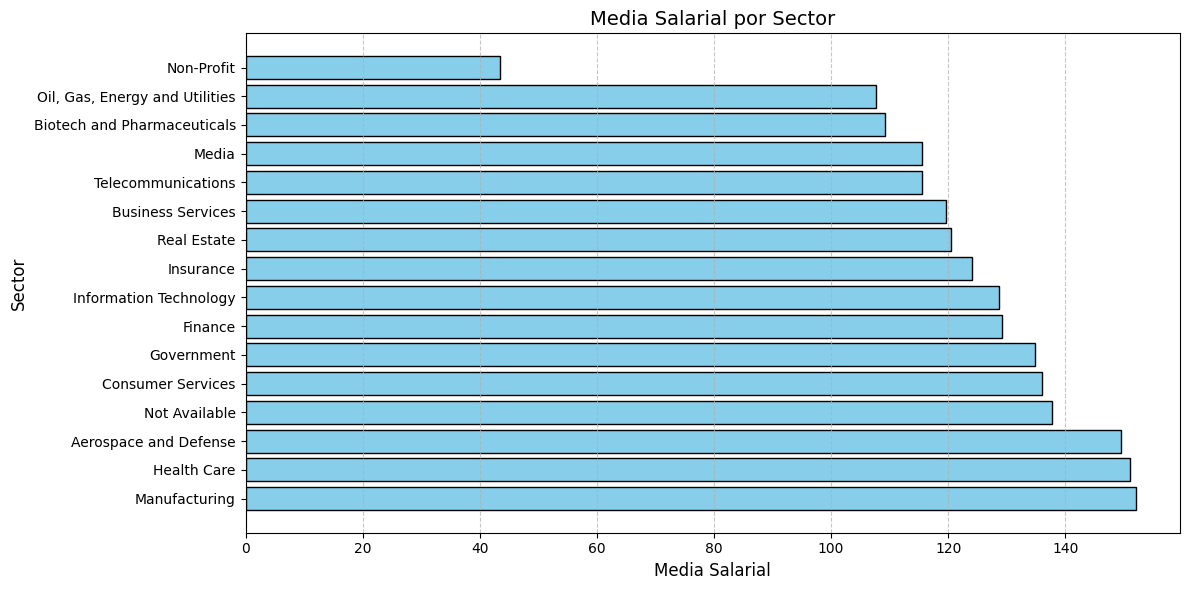

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

# Agrupar por industria y calcular el promedio de salario, redondeando a 2 decimales
df_out = df.groupBy("Sector").agg(F.round(F.avg("avg_salary"), 2).alias("media_sector"))

# Convertir el DataFrame de PySpark a Pandas para graficar
df_pd = df_out.toPandas()

# Ordenar el DataFrame por salario promedio para una visualización clara
df_pd = df_pd.sort_values(by="media_sector", ascending=False)

# Crear la gráfica
plt.figure(figsize=(12, 6))
plt.barh(df_pd["Sector"], df_pd["media_sector"], color='skyblue', edgecolor='black')
plt.title('Media Salarial por Sector', fontsize=14)
plt.xlabel('Media Salarial', fontsize=12)
plt.ylabel('Sector', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostrar la gráfica
plt.show()

Como vemos, los sectores que ahora mismo están pagando más en el mercado es manufacturing. Por otro lado, el sector que menos remunera, sería Oil, Gas, Energies and Utilities

Vamos a crear ahora una gráfica donde nos muestre el salario mínimo distinguiendo entre junior y senior

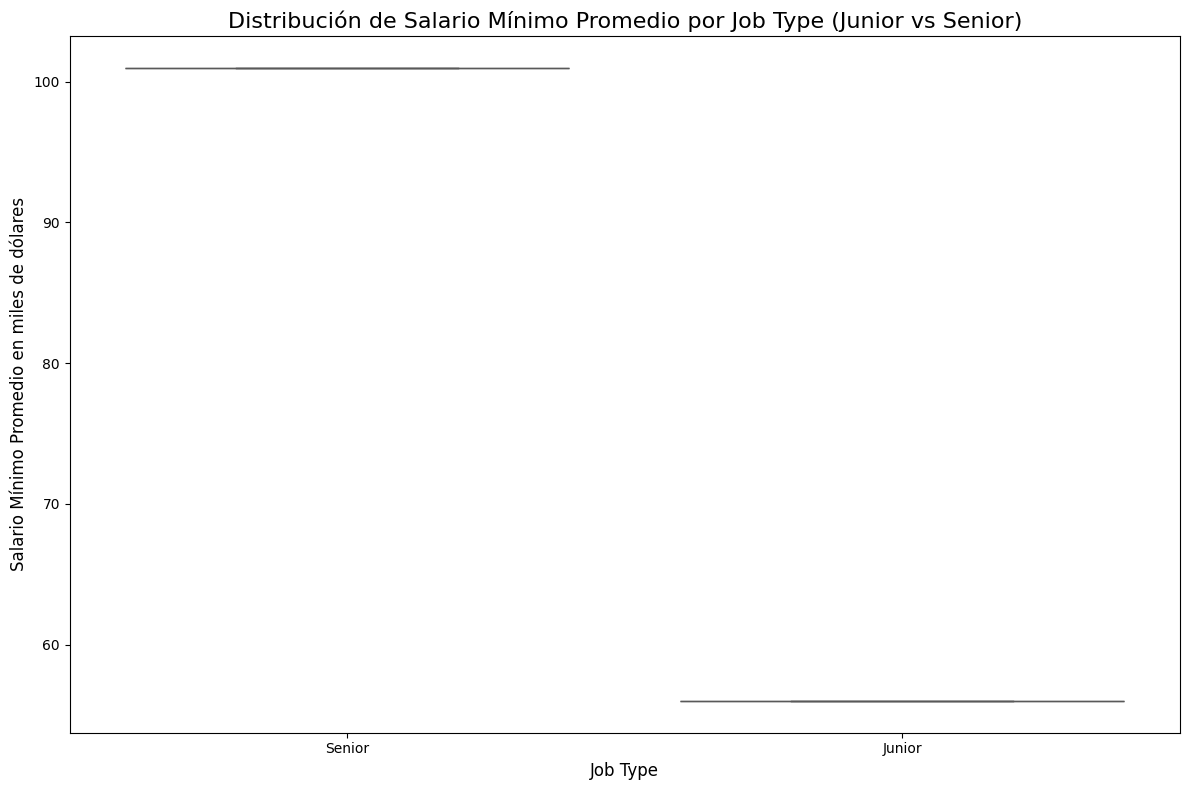

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Paso 1: Agrupar por 'Job Type' y 'Job Title' y calcular el salario mínimo promedio
df_grouped = df.groupBy("Job Type") \
    .agg(F.avg("min_salary").alias("avg_min_salary"))

# Paso 2: Convertir a pandas para graficar
df_pandas = df_grouped.toPandas()

# Paso 3: Filtrar por los valores 'Junior' y 'Senior' (si tienes otros tipos, ajusta)
df_filtered = df_pandas[df_pandas['Job Type'].isin(['Junior', 'Senior'])]

# Paso 4: Crear el gráfico (boxplot para comparar la distribución de salarios)
plt.figure(figsize=(12, 8))
sns.boxplot(x='Job Type', y='avg_min_salary', data=df_filtered, hue='Job Type', palette="Set2", legend=False)

# Personalizar el gráfico
plt.title('Distribución de Salario Mínimo Promedio por Job Type (Junior vs Senior)', fontsize=16)
plt.xlabel('Job Type', fontsize=12)
plt.ylabel('Salario Mínimo Promedio en miles de dólares', fontsize=12)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

Como podemos apreciar, el salario mínimo de los seniors es muchísimo mayor al de los Junior 😢

Ahora vamos a crear un gráfico donde veamos qué lenguaje está mas demandado, para ver qué aptitud sería más interesante desarrollar

<ipython-input-55-e6235cc5798b>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Language', y='Job Count', data=df_pandas_melted, palette="Set2")


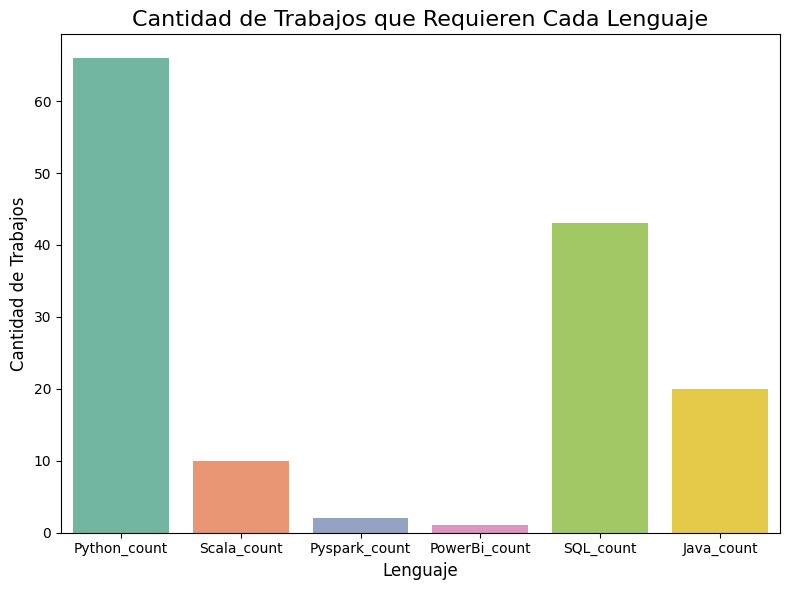

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql import functions as F

# Paso 1: Seleccionar las columnas de lenguajes
df_selected = df.select("Python", "Scala", "Pyspark", "PowerBi", "SQL", "Java")

# Paso 2: Contar cuántos trabajos requieren cada lenguaje (sumar las columnas)
df_count = df_selected.agg(
    F.sum("Python").alias("Python_count"),
    F.sum("Scala").alias("Scala_count"),
    F.sum("Pyspark").alias("Pyspark_count"),
    F.sum("PowerBi").alias("PowerBi_count"),
    F.sum("SQL").alias("SQL_count"),
    F.sum("Java").alias("Java_count")
)

# Paso 3: Convertir el resultado a pandas
df_pandas = df_count.toPandas()

# Paso 4: Transformar el DataFrame para tener una fila por lenguaje y su respectivo conteo
df_pandas_melted = df_pandas.melt(var_name="Language", value_name="Job Count")

# Paso 5: Crear el gráfico de barras
plt.figure(figsize=(8, 6))
sns.barplot(x='Language', y='Job Count', data=df_pandas_melted, palette="Set2")

# Personalizar el gráfico
plt.title('Cantidad de Trabajos que Requieren Cada Lenguaje', fontsize=16)
plt.xlabel('Lenguaje', fontsize=12)
plt.ylabel('Cantidad de Trabajos', fontsize=12)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


Vemos que python es un claro ganador con casi 70 ofertas de trabajo que demandan este lenguaje. Lo siguen SQL y Java, siendo ambos bastante solicitados

Por último, vamos a sacar un gráfico de quesos, en donde veamos el porcentaje de ofertas por cada Job Type que encontramos en los anuncios ofertantes. Es decir, la cantidad de ofertas para Junior, Senior y NA (ninguna)

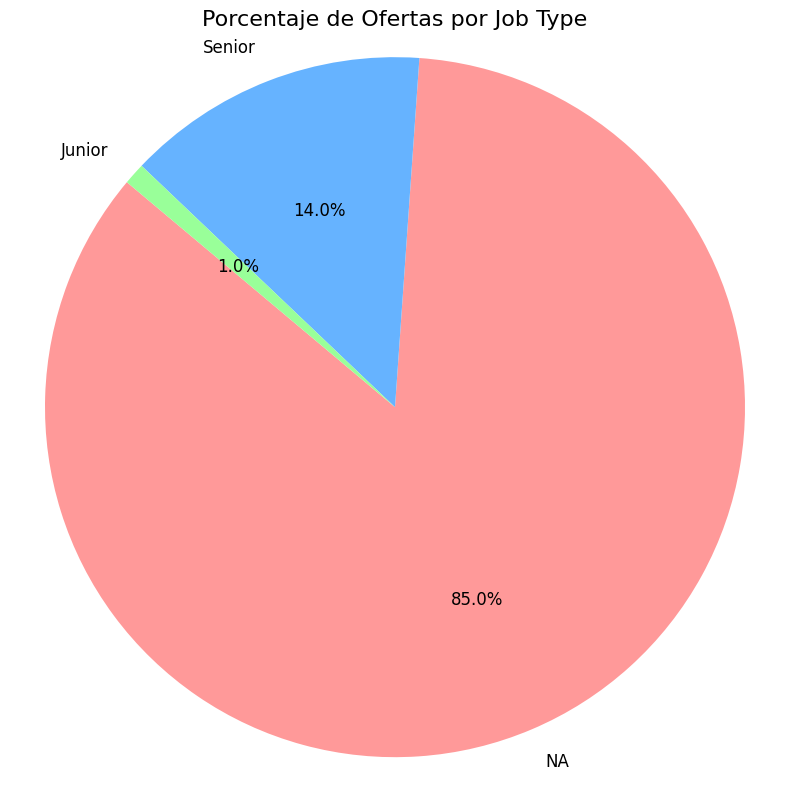

In [61]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# Paso 1: Agrupar por Job Type y contar las ofertas
df_job_type = df.groupBy("Job Type").agg(F.count("*").alias("count"))

# Paso 2: Calcular el total y el porcentaje
total_count = df_job_type.agg(F.sum("count").alias("total")).collect()[0]["total"]
df_job_type = df_job_type.withColumn("percentage", (F.col("count") / total_count) * 100)

# Paso 3: Convertir a Pandas
df_pandas = df_job_type.toPandas()

# Paso 4: Ordenar los datos por porcentaje (opcional, para estética)
df_pandas = df_pandas.sort_values(by='percentage', ascending=False)

# Paso 5: Crear el gráfico de pastel
plt.figure(figsize=(8, 8))  # Ajustar el tamaño del gráfico
colors = ['#ff9999', '#66b3ff', '#99ff99']  # Paleta personalizada para 3 categorías

# Crear el gráfico de pastel
plt.pie(
    df_pandas['percentage'],
    labels=df_pandas['Job Type'],  # Etiquetas directamente en el gráfico
    autopct='%1.1f%%',  # Mostrar porcentajes en los segmentos
    startangle=140,
    colors=colors,
    textprops={'fontsize': 12}  # Tamaño de fuente para las etiquetas
)

# Personalizar el gráfico
plt.title("Porcentaje de Ofertas por Job Type", fontsize=16)
plt.axis('equal')  # Asegurar que sea un círculo perfecto

# Mostrar el gráfico
plt.tight_layout()
plt.show()


Vemos como vuelve a predominar la apariencia de trabajos de Senior respecto a los Junior